In [ ]:
import os
import warnings

from db_queries import get_location_metadata
import pandas as pd

from covid_model_deaths import runner
from covid_model_deaths.deaths_io import InputsContext, MEASURES, Checkpoint
from covid_model_deaths.globals import COLUMNS

pd.options.display.max_rows = 99
pd.options.display.max_columns = 99
warnings.simplefilter('ignore')

RUN_TYPE = 'prod'
DATA_VERSION = 'best'
DATESTAMP_LABEL = '2020_04_30_US'

PEAK_FILE = '/ihme/covid-19/deaths/mobility_inputs/2020_04_14/final_peak_locs_04_14.csv'
PEAK_DURATION_FILE = None
R0_FILE = None
LOCATION_SET_VERSION = 655
r0_locs = []

CODE_DIR = os.path.abspath('../src/covid_model_deaths')
OUTPUT_DIR = f'/ihme/covid-19/deaths/{RUN_TYPE}/{DATESTAMP_LABEL}'
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
checkpoint = Checkpoint(OUTPUT_DIR)
inputs = InputsContext(f'/ihme/covid-19/model-inputs/{DATA_VERSION}')


print(f'Writing to {OUTPUT_DIR}')
print(CODE_DIR)
print(checkpoint)

raw_draw_path = f'{OUTPUT_DIR}/state_data.csv'
average_draw_path = f'{OUTPUT_DIR}/past_avg_state_data.csv'
yesterday_draw_path = '/ihme/covid-19/deaths/prod/2020_04_29_US/state_data.csv'
before_yesterday_draw_path = '/ihme/covid-19/deaths/prod/2020_04_28_US/state_data.csv'


def filter_data(data: pd.DataFrame) -> pd.DataFrame:
    """Remove bad or problematic data locations and dates."""
    return data

def get_locations(location_set_version_id):
    loc_df = get_location_metadata(location_set_id=111,
                                   location_set_version_id=location_set_version_id)
    most_detailed = loc_df['most_detailed'] == 1
    us = loc_df['path_to_top_parent'].str.startswith('102,')
    keep_columns = ['location_id', 'location_ascii_name', 'parent_id', 'level', 'most_detailed']

    us_df = loc_df.loc[most_detailed & us, keep_columns]
    us_df = us_df.rename(columns={'location_ascii_name': 'Location'})

    # Add parents
    loc_df = loc_df[['location_id', 'location_ascii_name']]
    loc_df = loc_df.rename(columns={'location_id':'parent_id',
                                    'location_ascii_name':'Country/Region'})

    us_df = us_df.merge(loc_df)
    us_df = us_df.loc[:, ['location_id', 'Location', 'Country/Region', 'level']]
    return us_df


## read full (unrestricted) set from snapshot

In [ ]:
loc_df = get_locations(LOCATION_SET_VERSION)
input_full_df = filter_data(inputs.load(MEASURES.full_data))
input_death_df = filter_data(inputs.load(MEASURES.deaths))
input_age_pop_df = inputs.load(MEASURES.age_pop)
input_age_death_df = inputs.load(MEASURES.age_death)

# Save pops for Bobby.
inputs.load(MEASURES.us_pops).to_csv(f'{OUTPUT_DIR}/pops.csv', index=False)

checkpoint.write('location', loc_df)
checkpoint.write('full_data', input_full_df)
checkpoint.write('deaths', input_death_df)
checkpoint.write('age_pop', input_age_pop_df)
checkpoint.write('age_death', input_age_death_df)

## combine back-casted death rates with cases for abie (using model dataset, i.e. admin1 and below)

In [ ]:
%%time
full_df = checkpoint.load('full_data')
death_df = checkpoint.load('deaths')
age_pop_df = checkpoint.load('age_pop')
age_death_df = checkpoint.load('age_death')

backcast_location_ids = runner.get_backcast_location_ids(full_df)
cases_and_backcast_deaths_df = runner.make_cases_and_backcast_deaths(full_df, death_df,
                                                                     age_pop_df, age_death_df,
                                                                     backcast_location_ids)

cases_and_backcast_deaths_df.to_csv(f'{OUTPUT_DIR}/backcast_for_case_to_death.csv', index=False)
checkpoint.write('cases_and_backcast_deaths', cases_and_backcast_deaths_df)

## Impute death thresholds.

In [ ]:
%%time
cases_and_backcast_deaths_df = checkpoint.load('cases_and_backcast_deaths')
loc_df = checkpoint.load('location')
threshold_dates = runner.impute_death_threshold(cases_and_backcast_deaths_df,
                                                loc_df)
threshold_dates.to_csv(f'{OUTPUT_DIR}/threshold_dates.csv', index=False)
checkpoint.write('threshold_dates', threshold_dates)

## Make last day data

In [ ]:
full_df = checkpoint.load('full_data')
threshold_dates = checkpoint.load('threshold_dates')

date_mean_df = runner.make_date_mean_df(threshold_dates)
last_day_df = runner.make_last_day_df(full_df,date_mean_df)
last_day_df.to_csv(f'{OUTPUT_DIR}/last_day.csv', index=False)

checkpoint.write('date_mean', date_mean_df)
checkpoint.write('last_day', last_day_df)

## Get leading indicator

In [ ]:
full_df = checkpoint.load('full_data')
loc_df = checkpoint.load('location')

dcr_df, dhr_df, leading_indicator_df = runner.make_leading_indicator(
    full_df.loc[full_df[COLUMNS.location_id].isin(loc_df[COLUMNS.location_id].to_list())]
)
dcr_df.to_csv(f'{OUTPUT_DIR}/lagged_death_to_case_ratios.csv', index=False)
dhr_df.to_csv(f'{OUTPUT_DIR}/lagged_death_to_hosp_ratios.csv', index=False)
leading_indicator_df.to_csv(f'{OUTPUT_DIR}/leading_indicator.csv', index=False)
leading_indicator_df = leading_indicator_df[[COLUMNS.location_id, COLUMNS.date, COLUMNS.ln_age_death_rate]]
leading_indicator_df = leading_indicator_df.loc[~leading_indicator_df[COLUMNS.ln_age_death_rate].isnull()]

checkpoint.write('leading_indicator', leading_indicator_df)

## Submit models

In [3]:
full_df = checkpoint.load('full_data')
death_df = checkpoint.load('deaths')
age_pop_df = checkpoint.load('age_pop')
age_death_df = checkpoint.load('age_death')
date_mean_df = checkpoint.load('date_mean')
last_day_df = checkpoint.load('last_day')
leading_indicator_df = checkpoint.load('leading_indicator')
loc_df = checkpoint.load('location')

submodel_dict = runner.submit_models(full_df, death_df, age_pop_df, age_death_df, date_mean_df, leading_indicator_df,
                                     loc_df, r0_locs,
                                     PEAK_FILE, OUTPUT_DIR, DATA_VERSION, R0_FILE, CODE_DIR, verbose=False)

checkpoint.write('submodel_dict', submodel_dict)

2020-05-01 08:35:39.837 | INFO     | covid_model_deaths.deaths_io.checkpoint:load:30 - Loading full_data from in memory cache.
2020-05-01 08:35:39.839 | INFO     | covid_model_deaths.deaths_io.checkpoint:load:30 - Loading deaths from in memory cache.
2020-05-01 08:35:39.840 | INFO     | covid_model_deaths.deaths_io.checkpoint:load:30 - Loading age_pop from in memory cache.
2020-05-01 08:35:39.841 | INFO     | covid_model_deaths.deaths_io.checkpoint:load:30 - Loading age_death from in memory cache.
2020-05-01 08:35:39.842 | INFO     | covid_model_deaths.deaths_io.checkpoint:load:30 - Loading date_mean from in memory cache.
2020-05-01 08:35:39.844 | INFO     | covid_model_deaths.deaths_io.checkpoint:load:30 - Loading last_day from in memory cache.
2020-05-01 08:35:39.845 | INFO     | covid_model_deaths.deaths_io.checkpoint:load:30 - Loading leading_indicator from in memory cache.
2020-05-01 08:35:39.846 | INFO     | covid_model_deaths.deaths_io.checkpoint:load:30 - Loading location from 

## compile draws

2020-05-01 08:43:32.513 | INFO     | covid_model_deaths.deaths_io.checkpoint:load:30 - Loading full_data from in memory cache.
2020-05-01 08:43:32.514 | INFO     | covid_model_deaths.deaths_io.checkpoint:load:30 - Loading age_pop from in memory cache.
2020-05-01 08:43:32.515 | INFO     | covid_model_deaths.deaths_io.checkpoint:load:32 - Reading threshold_dates from checkpoint dir /ihme/covid-19/deaths/prod/2020_04_30_US/checkpoint.
2020-05-01 08:43:32.521 | INFO     | covid_model_deaths.deaths_io.checkpoint:load:30 - Loading submodel_dict from in memory cache.
2020-05-01 08:43:32.522 | INFO     | covid_model_deaths.deaths_io.checkpoint:load:30 - Loading location from in memory cache.
100%|██████████| 53/53 [00:07<00:00,  7.53it/s]


/ihme/covid-19/deaths/prod/2020_04_30_US/ensemble_plot.pdf


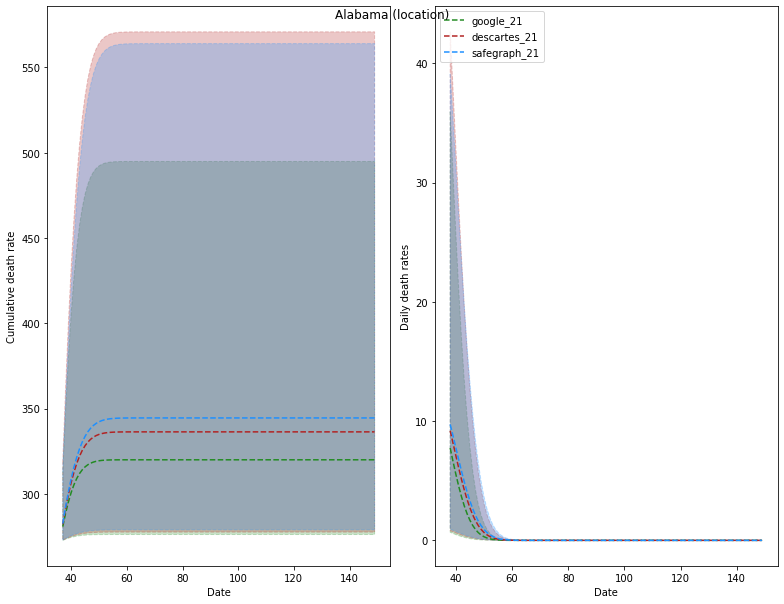

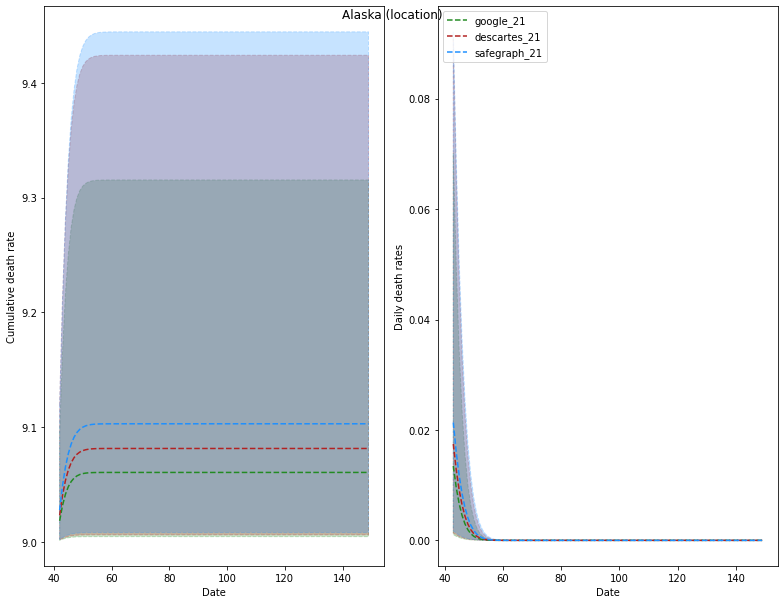

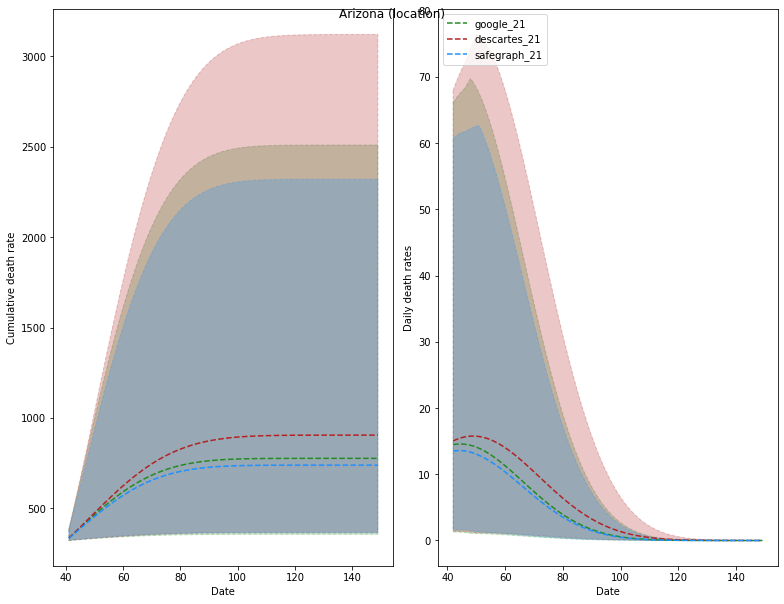

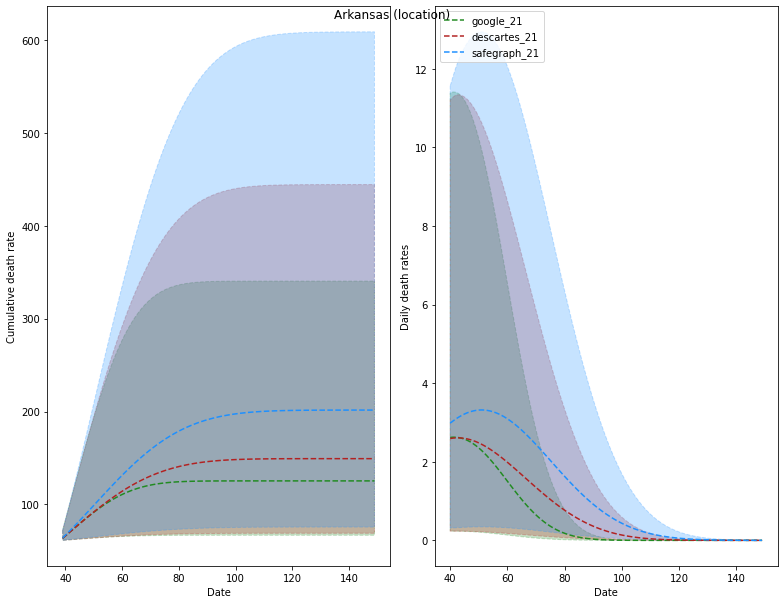

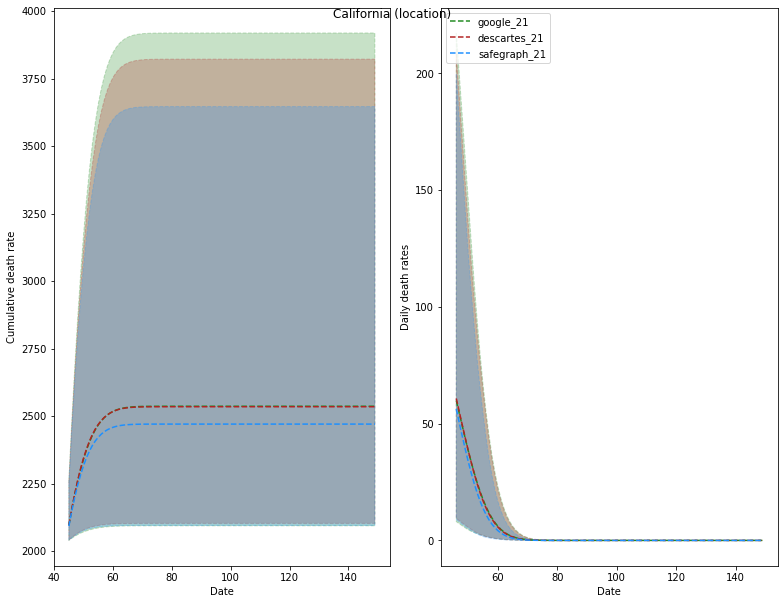

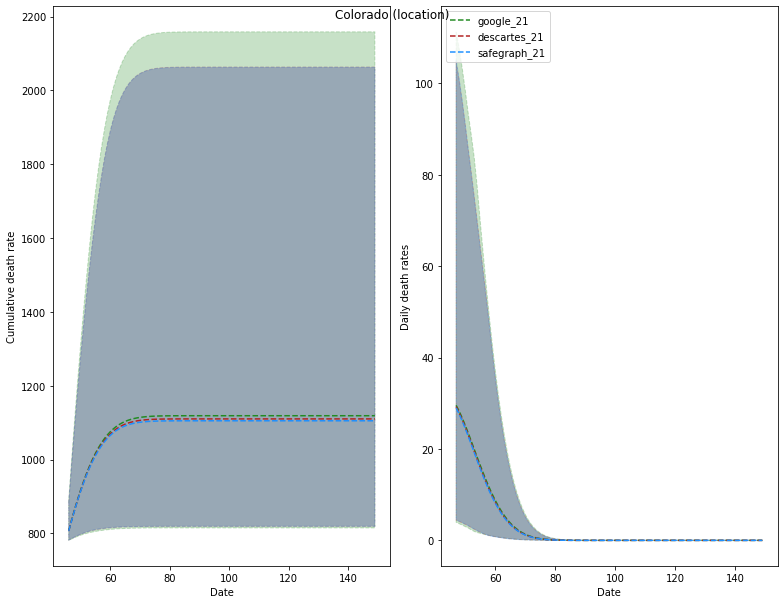

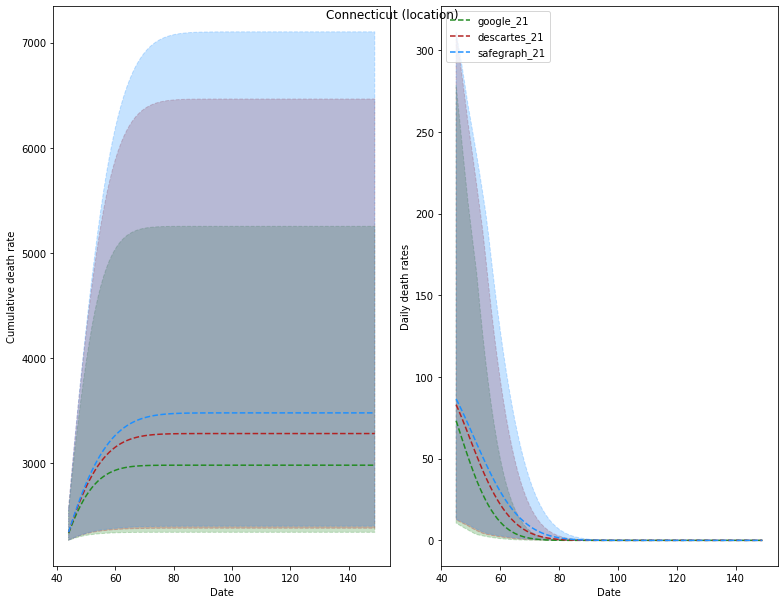

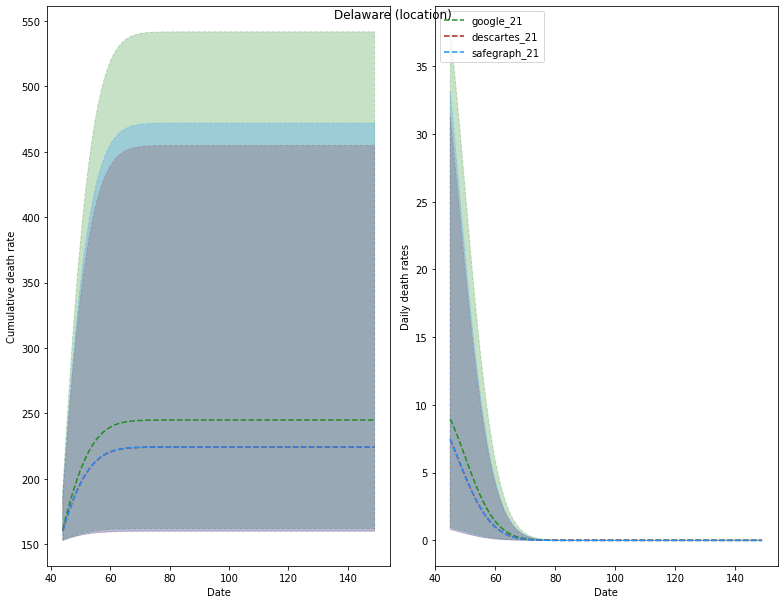

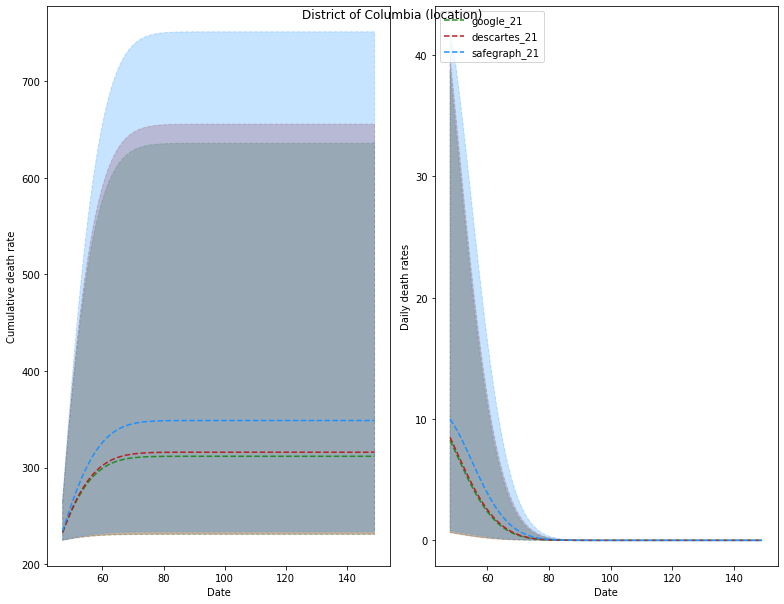

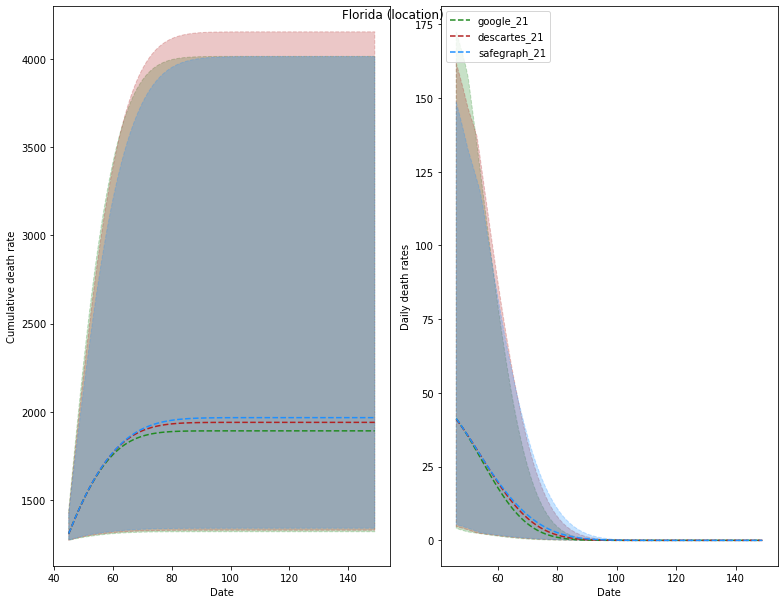

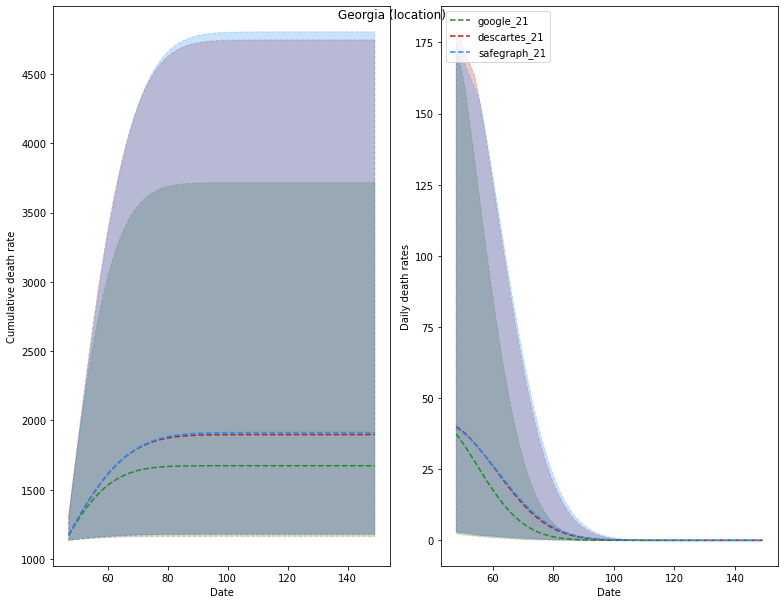

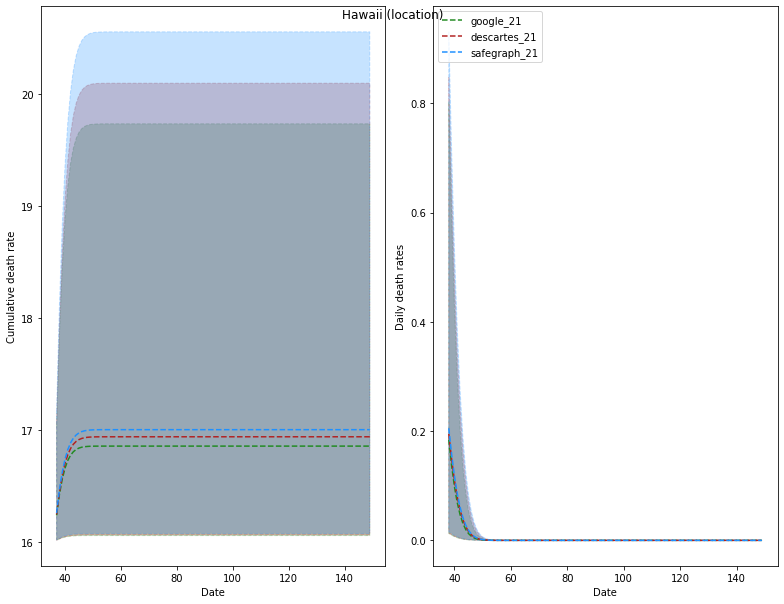

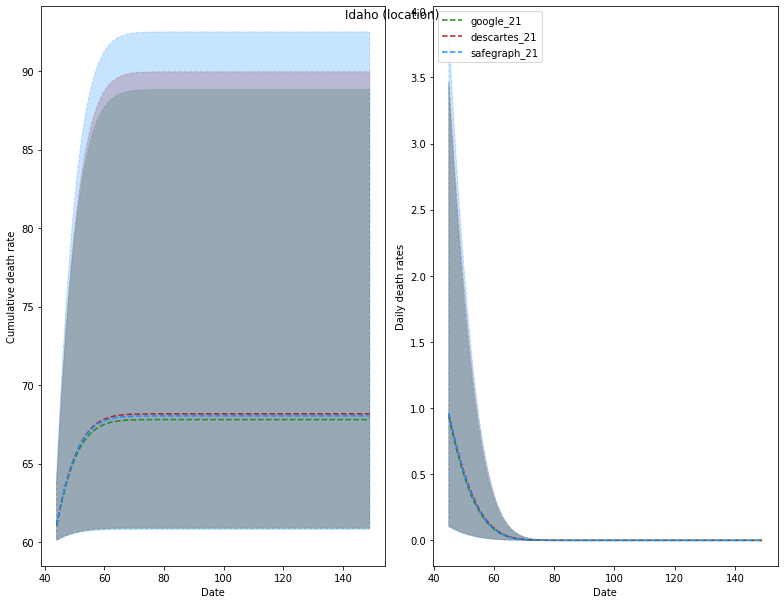

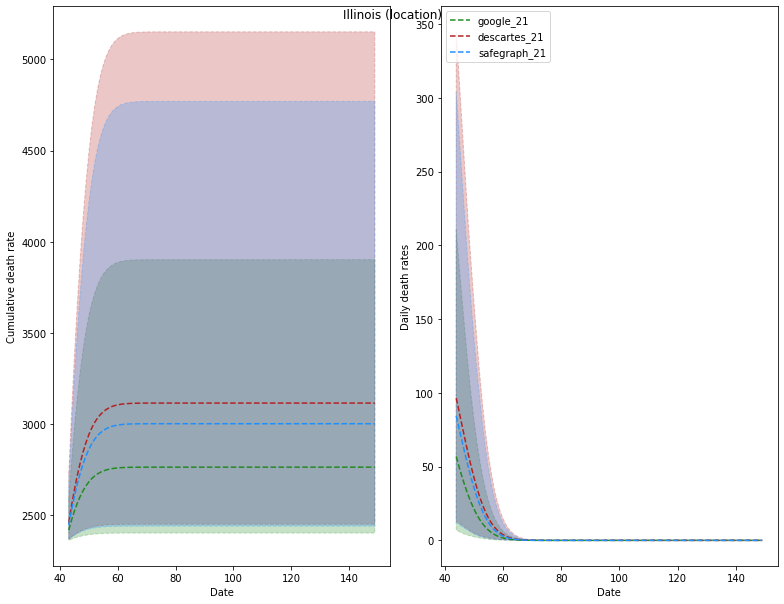

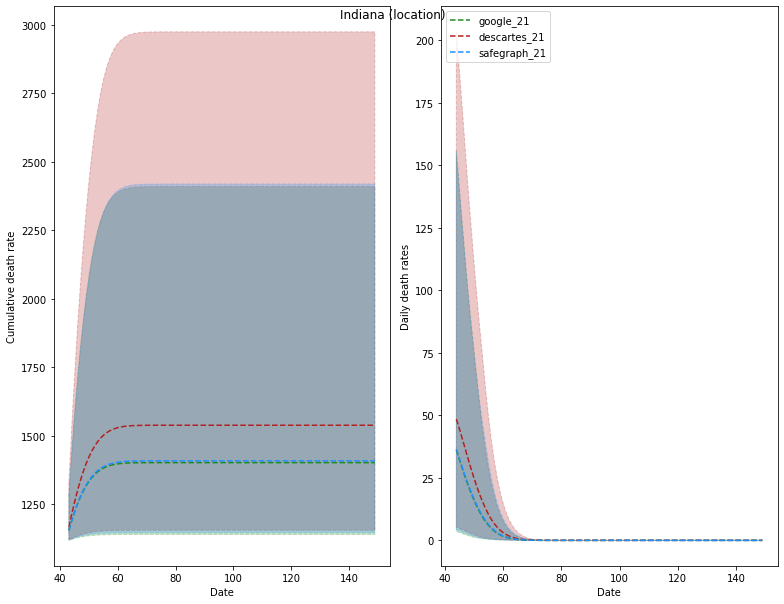

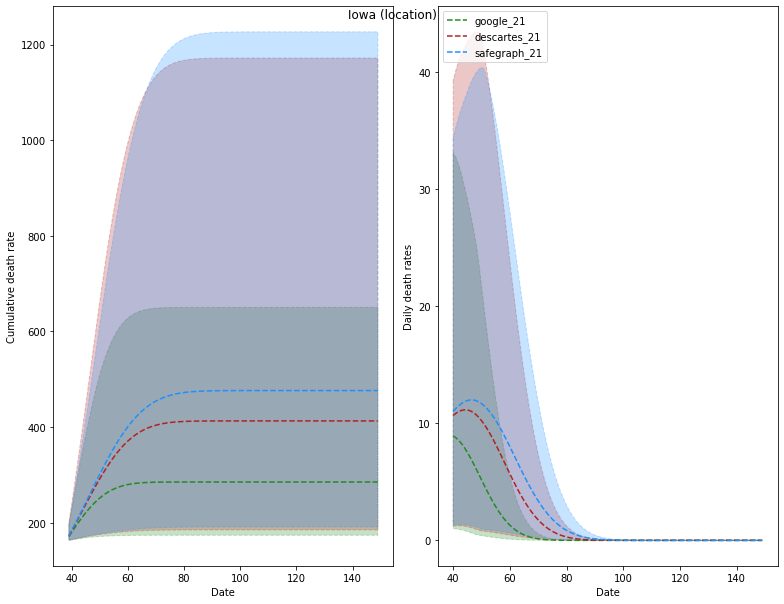

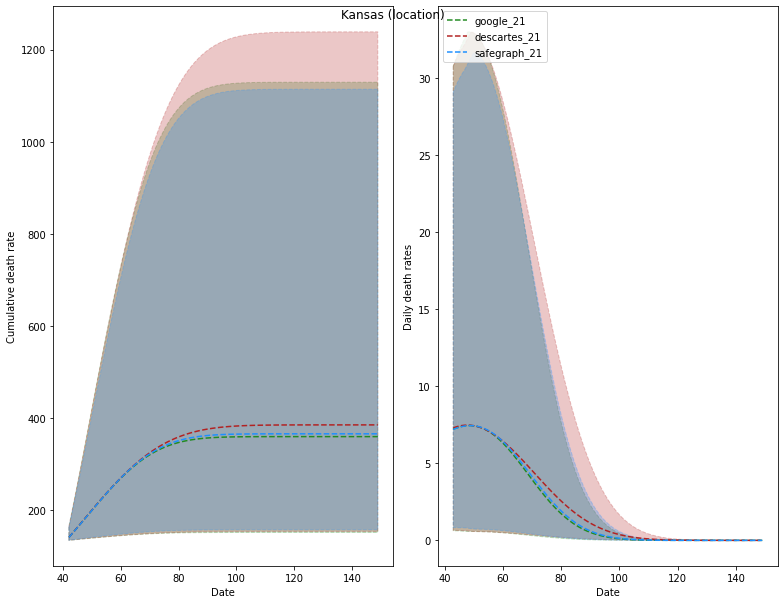

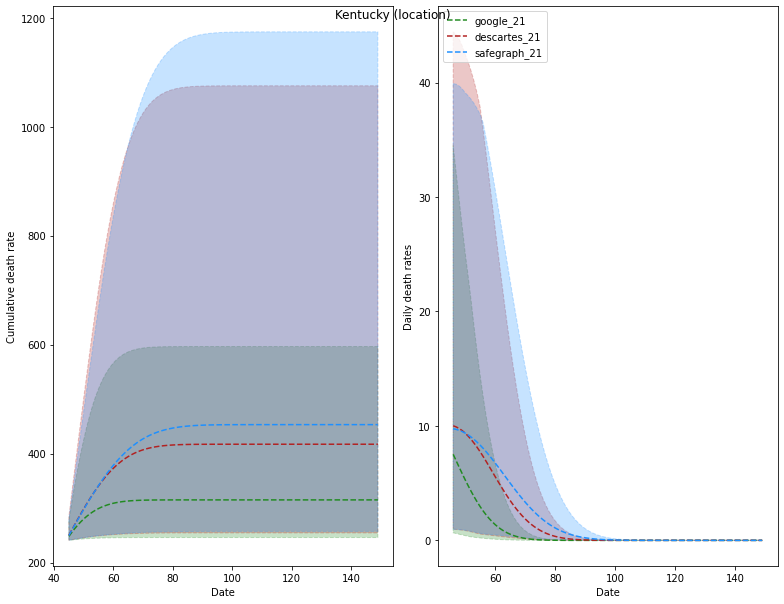

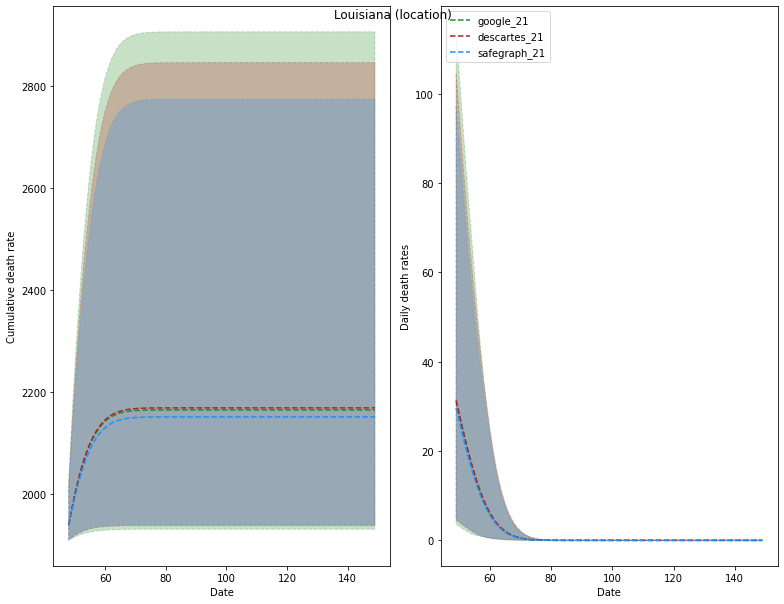

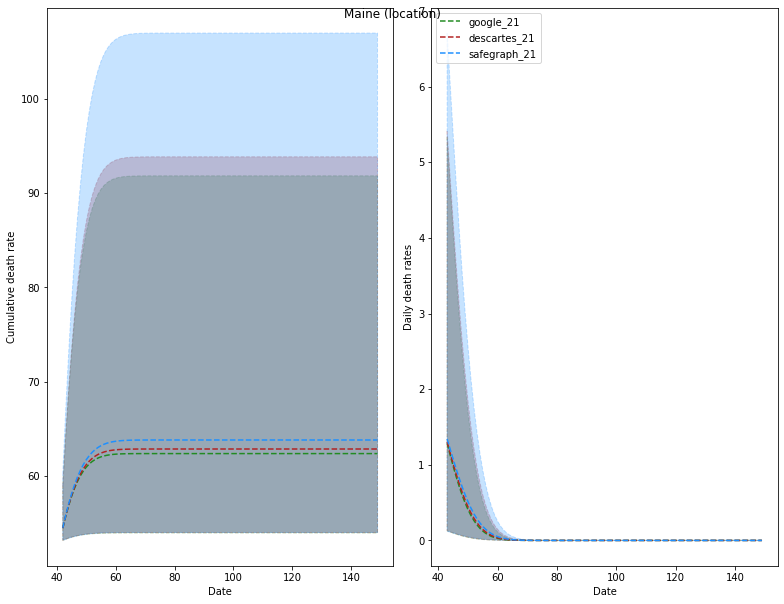

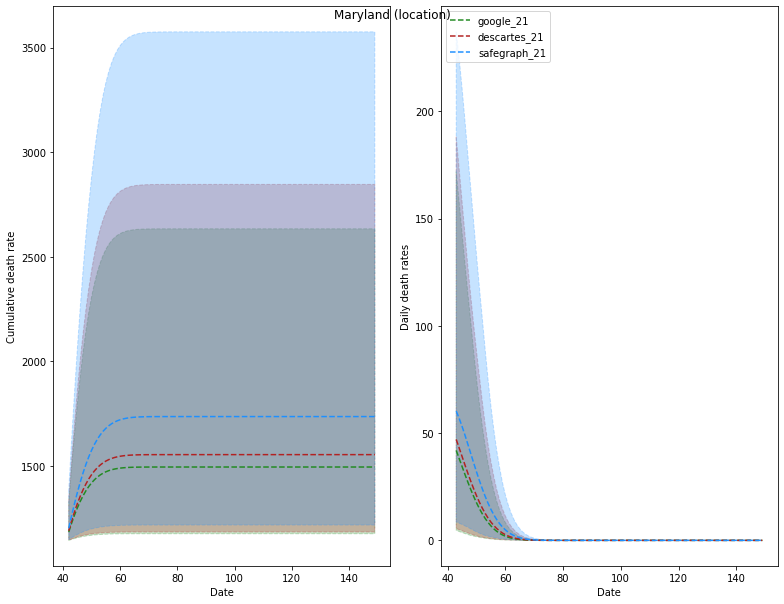

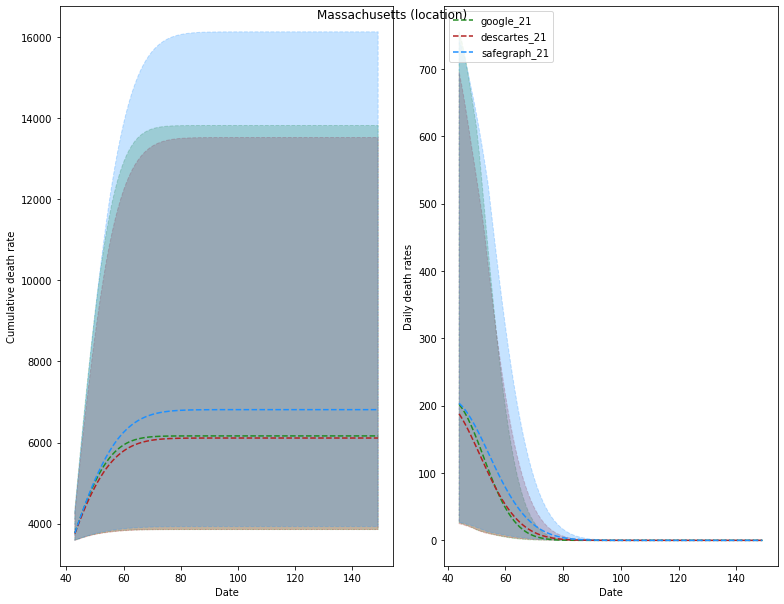

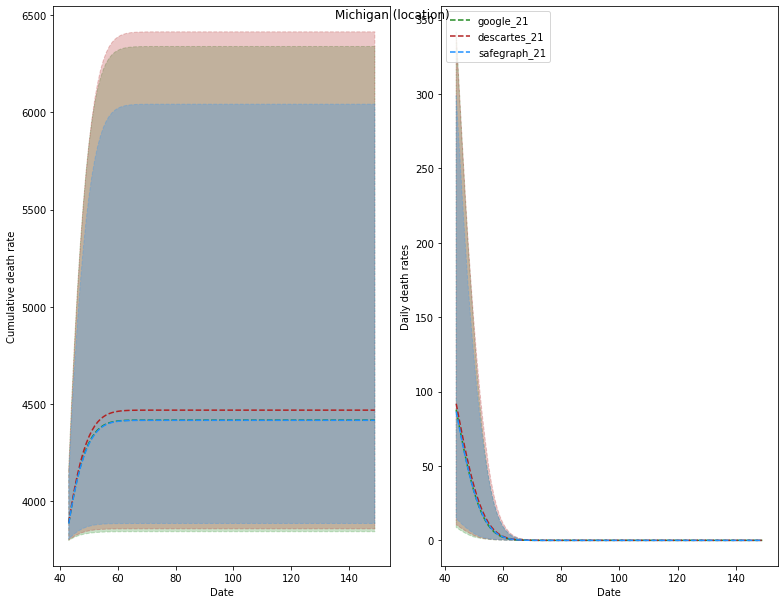

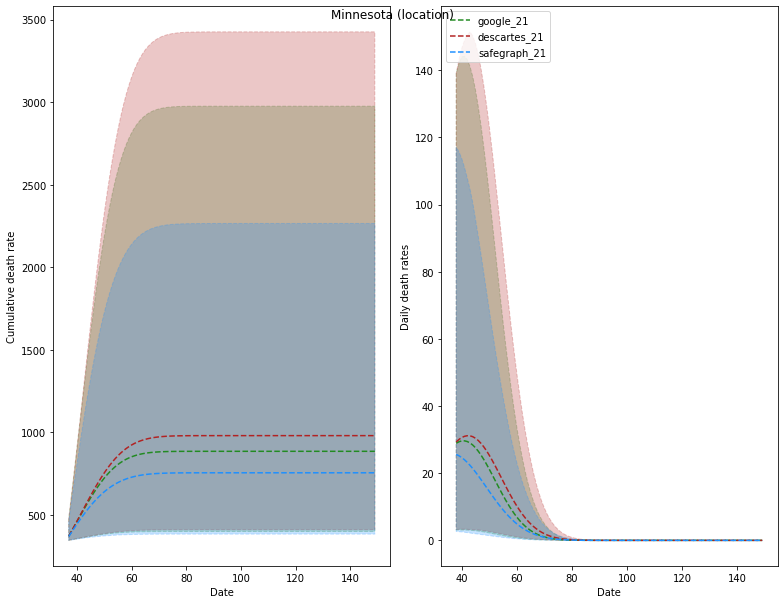

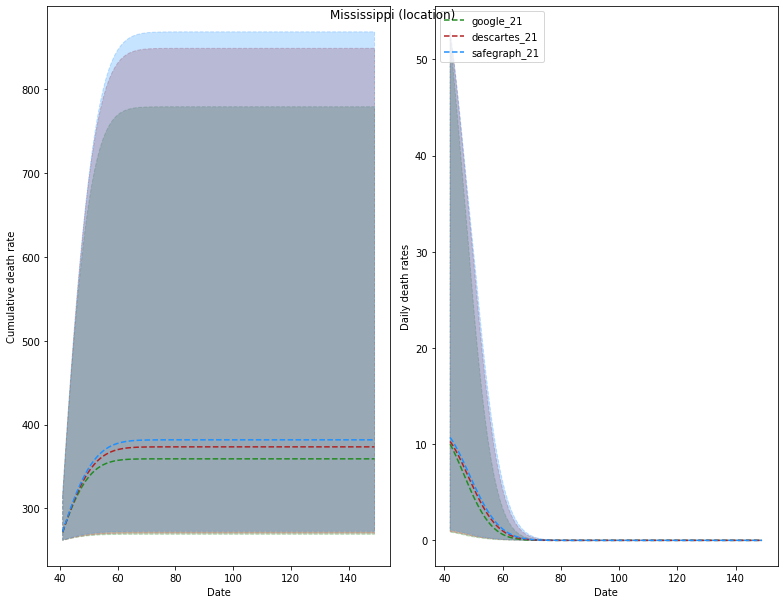

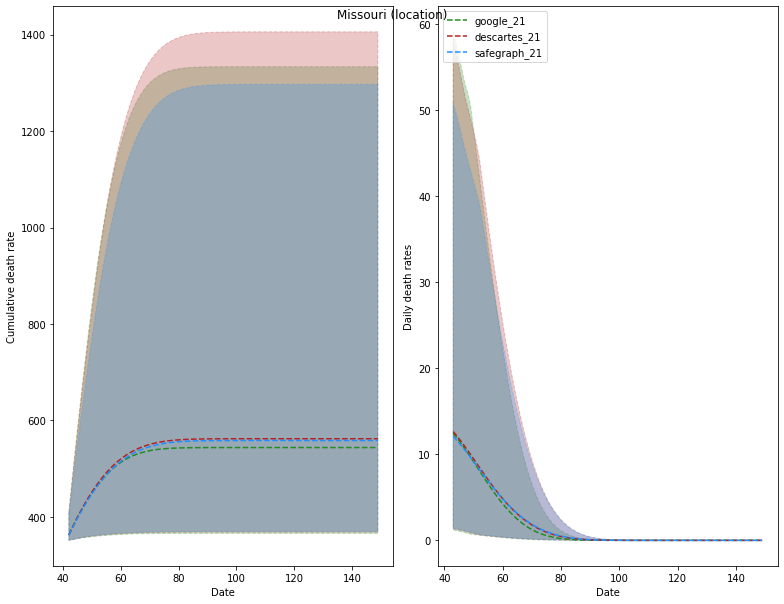

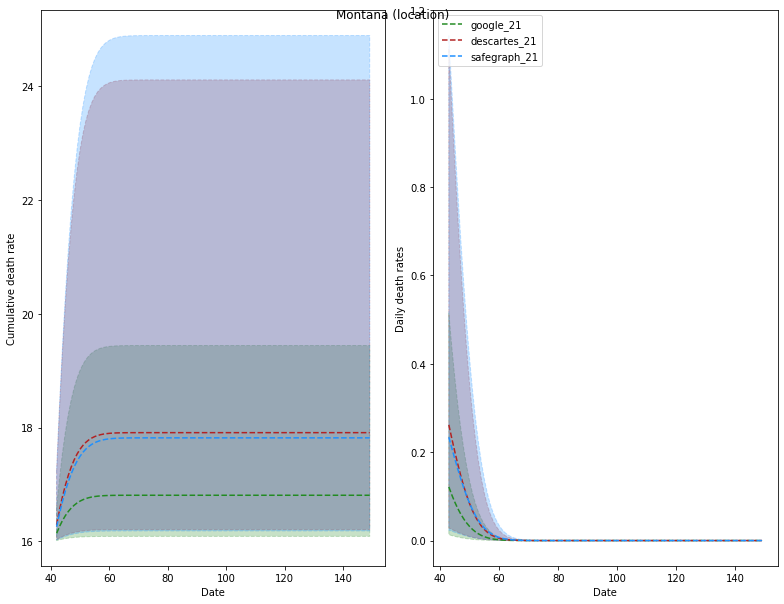

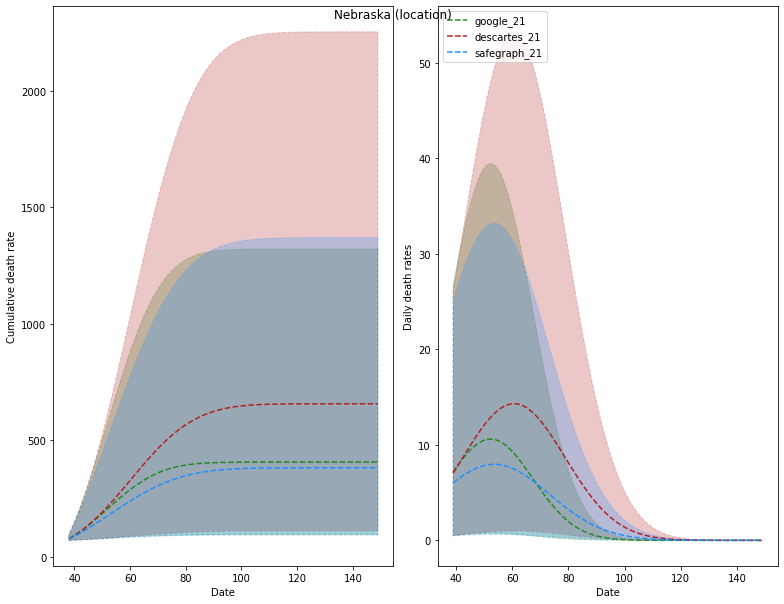

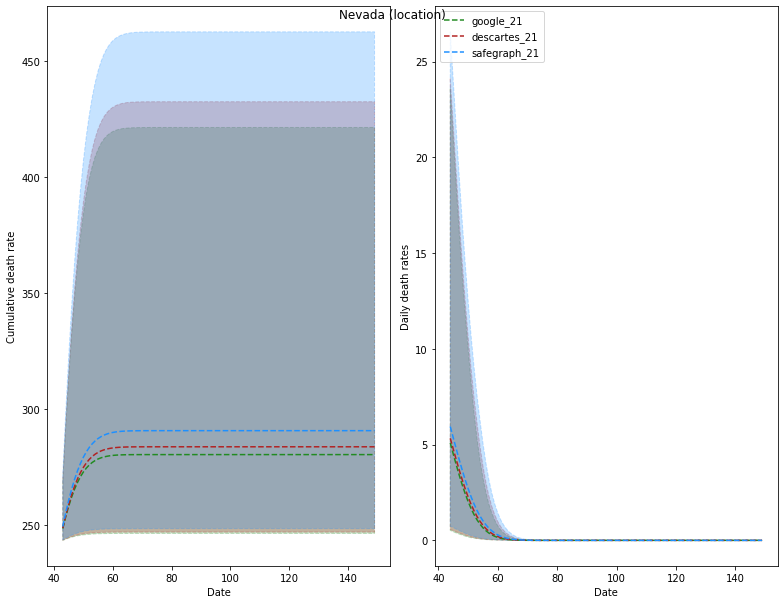

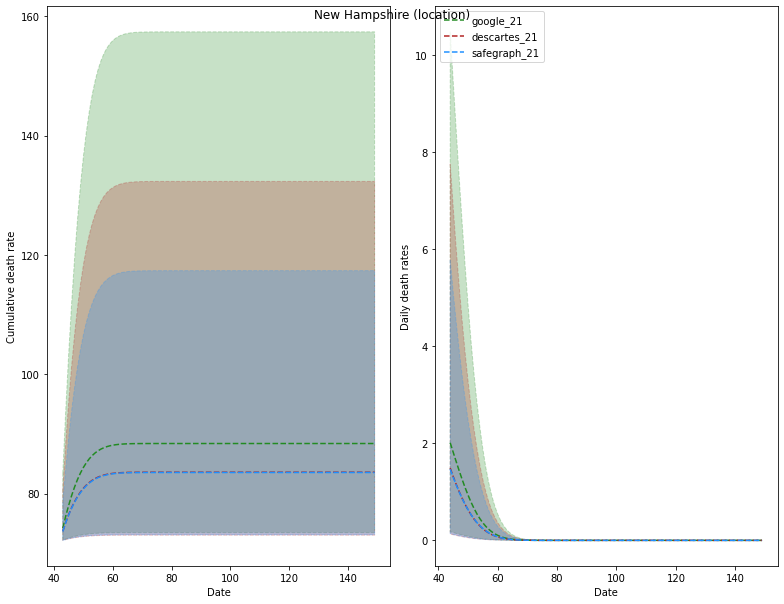

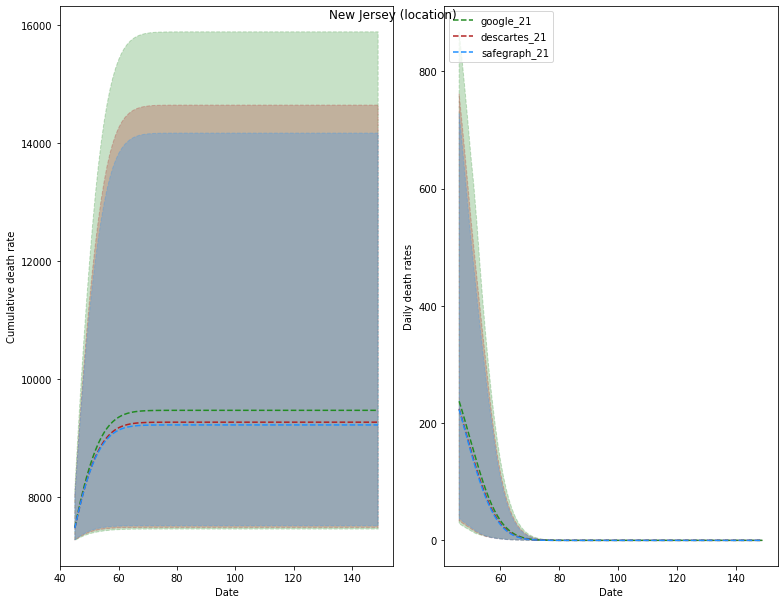

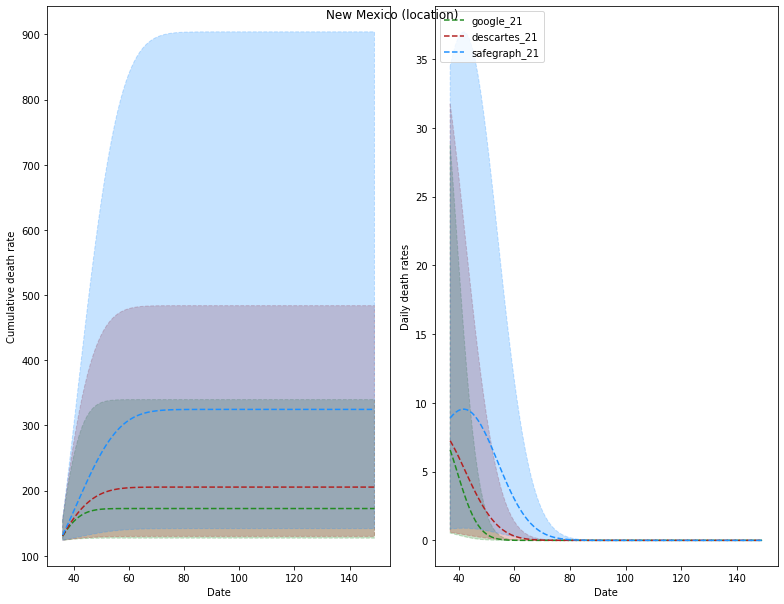

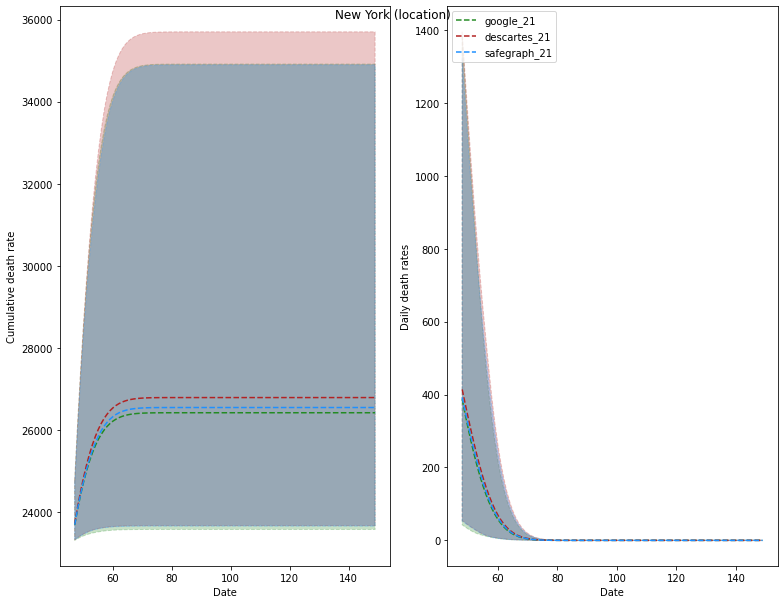

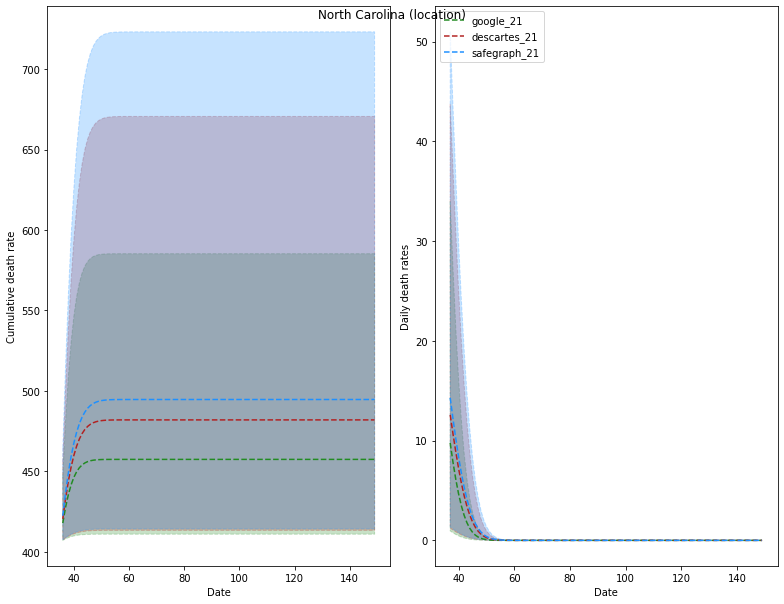

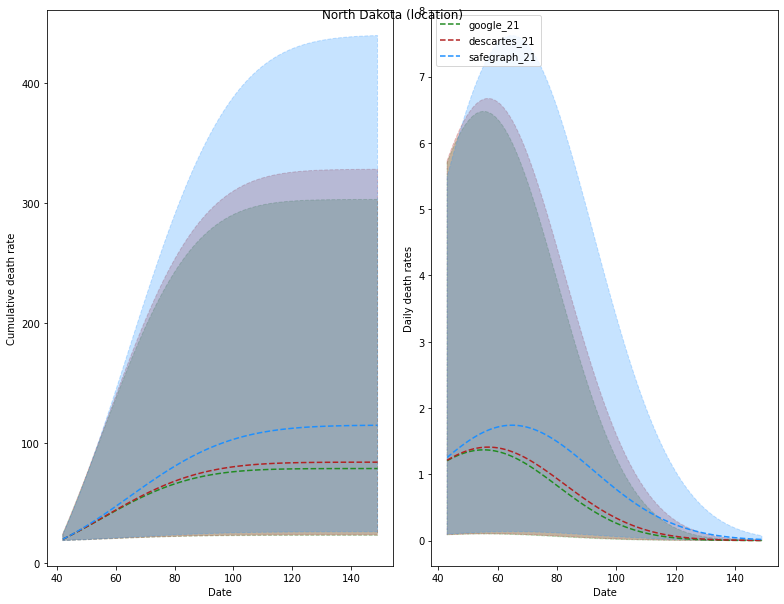

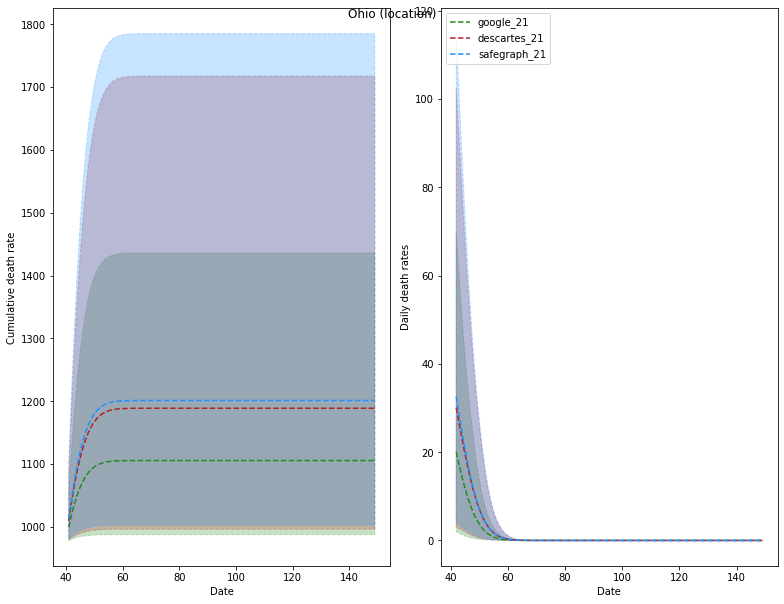

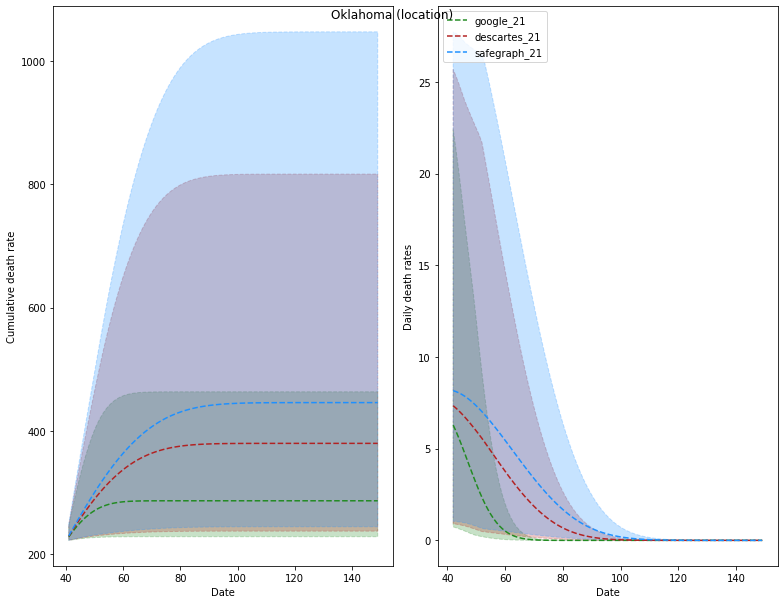

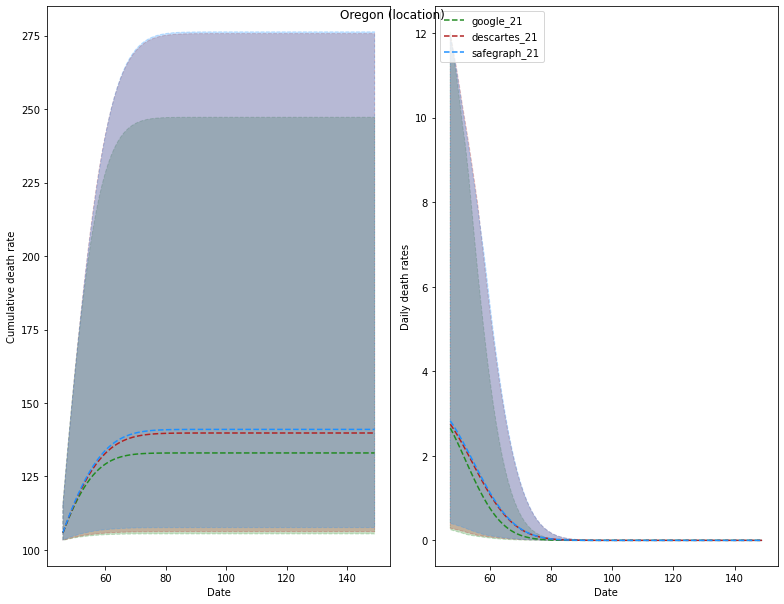

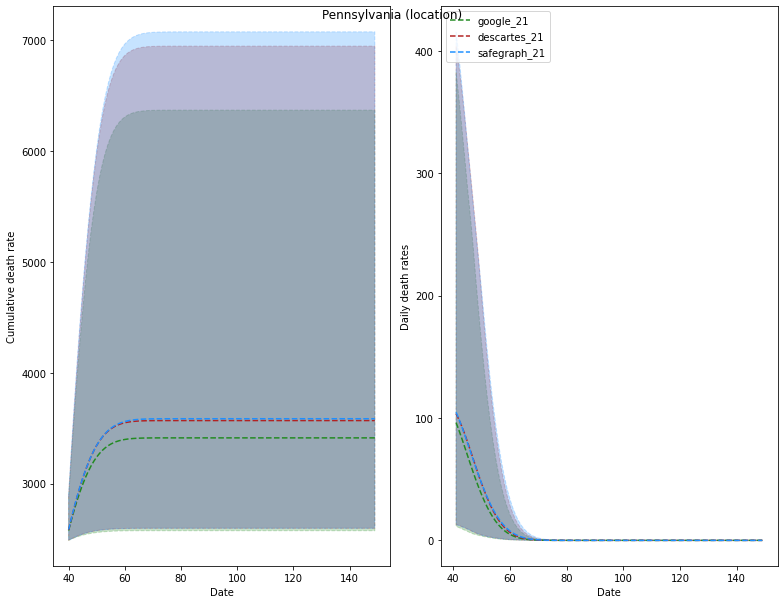

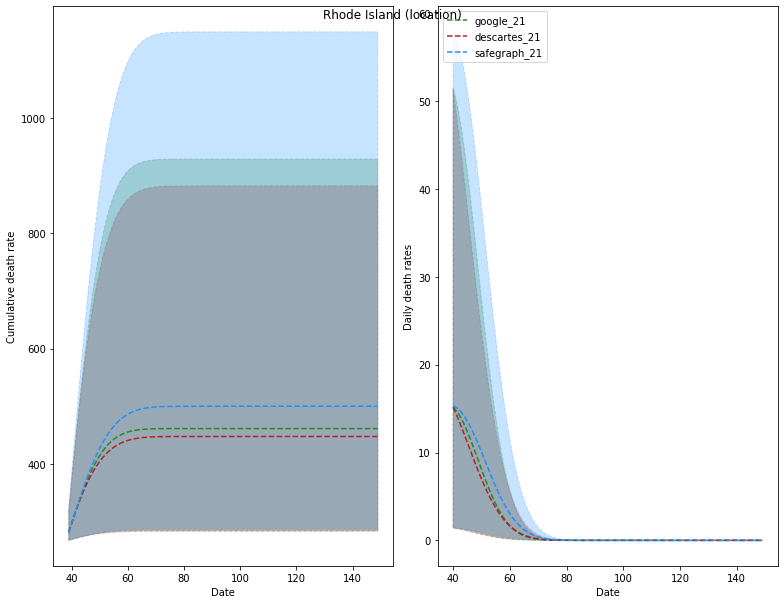

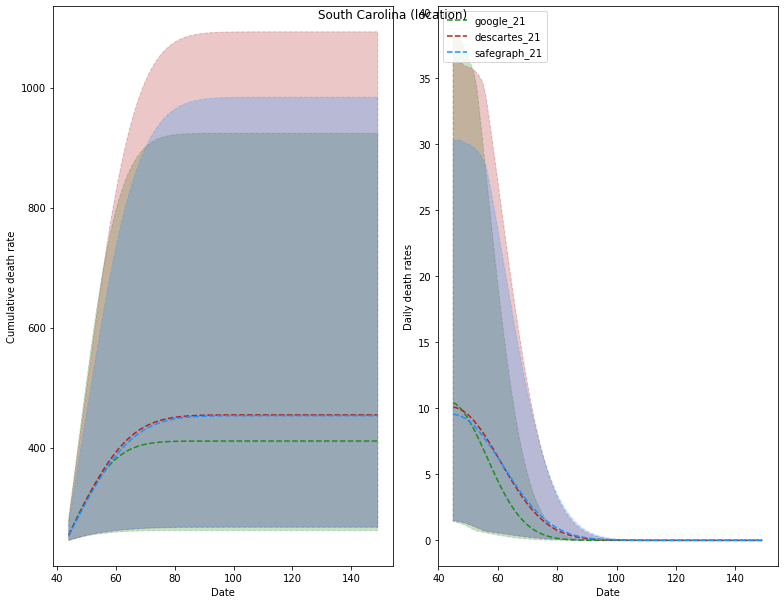

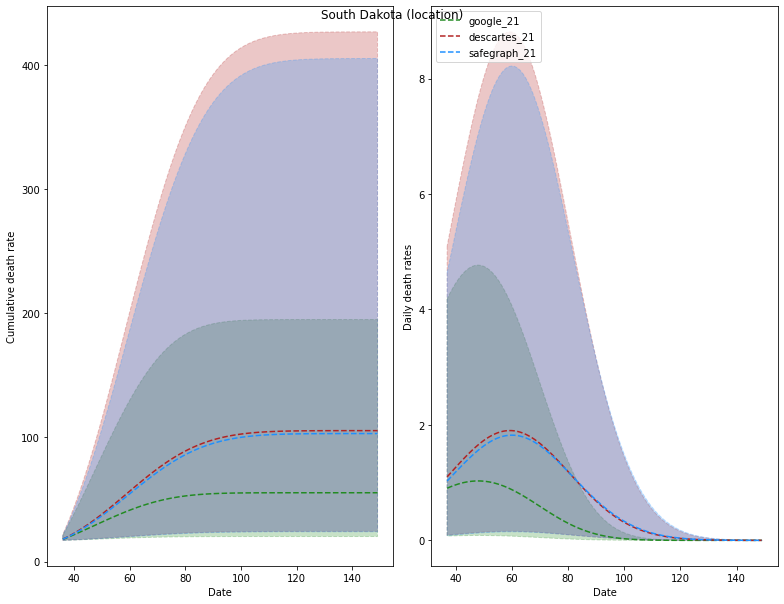

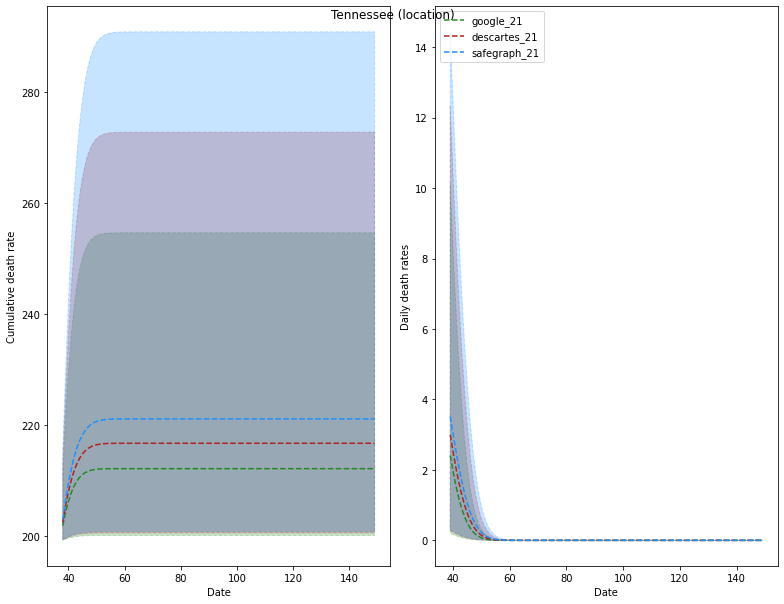

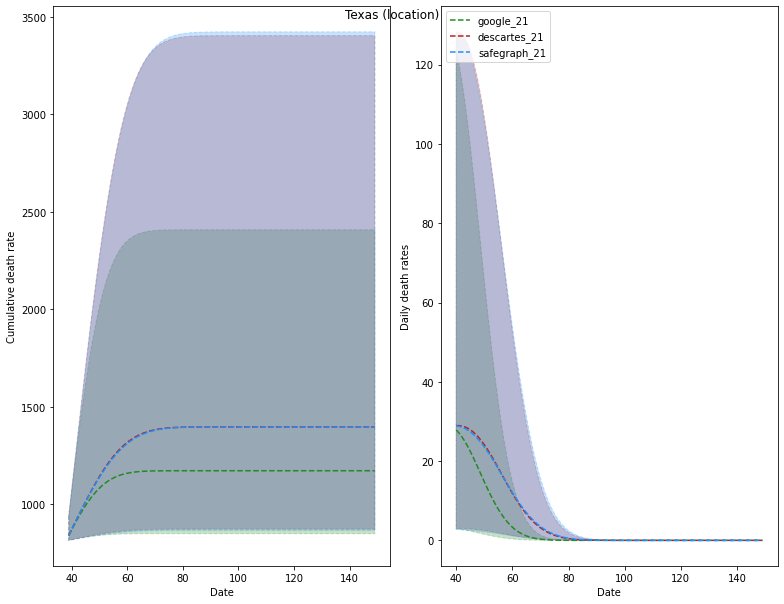

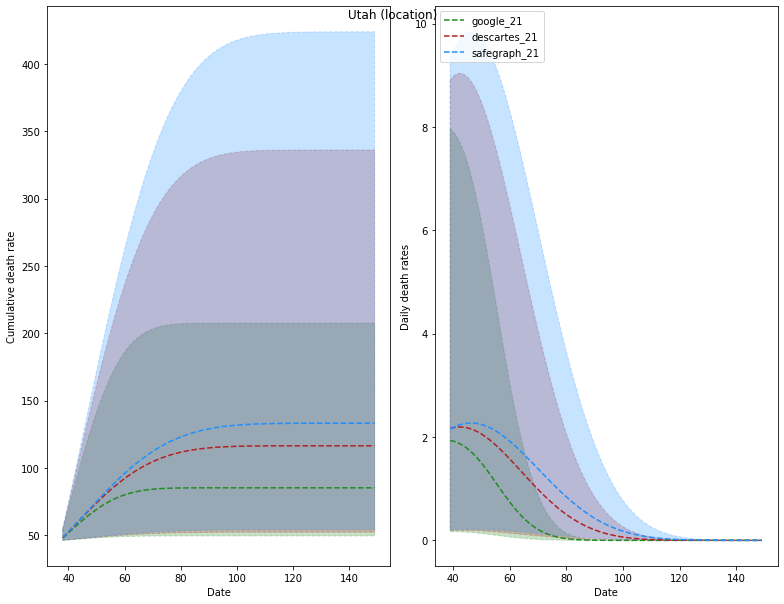

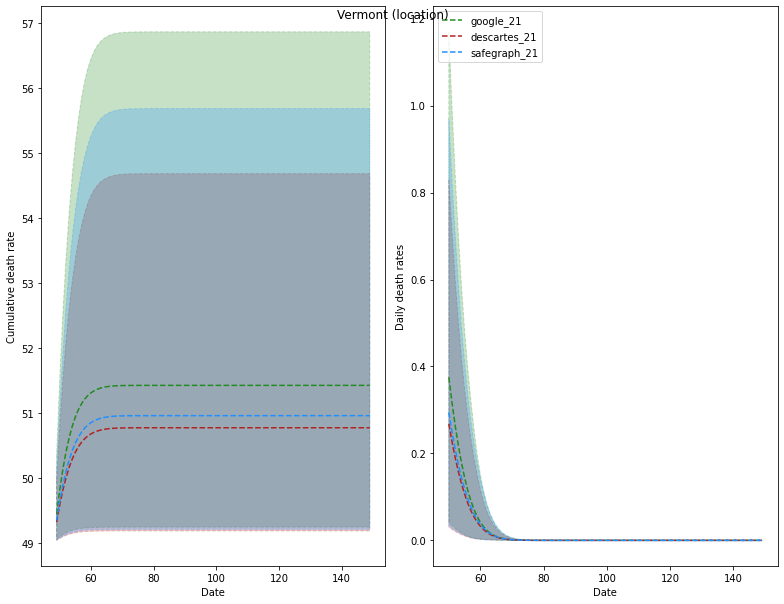

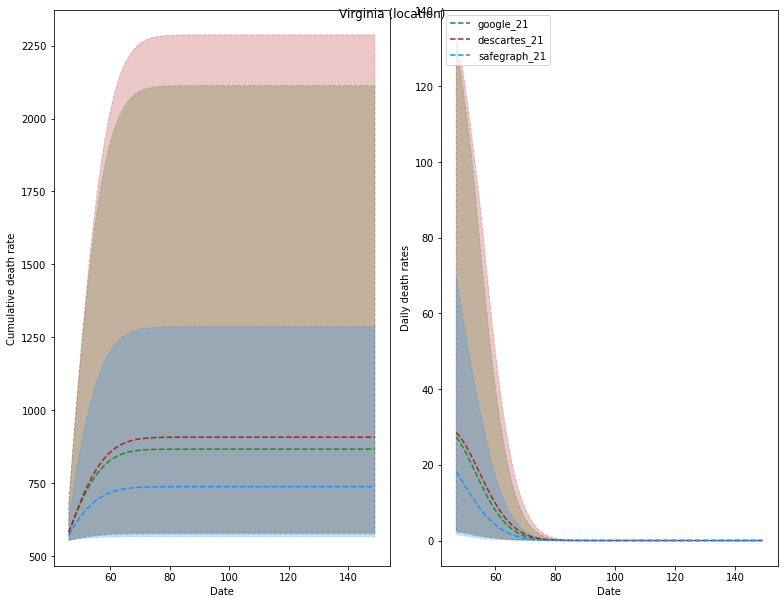

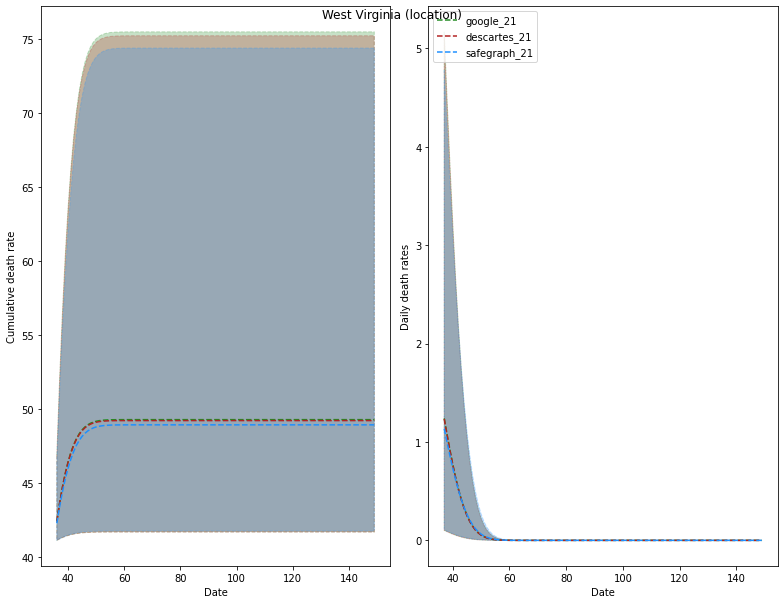

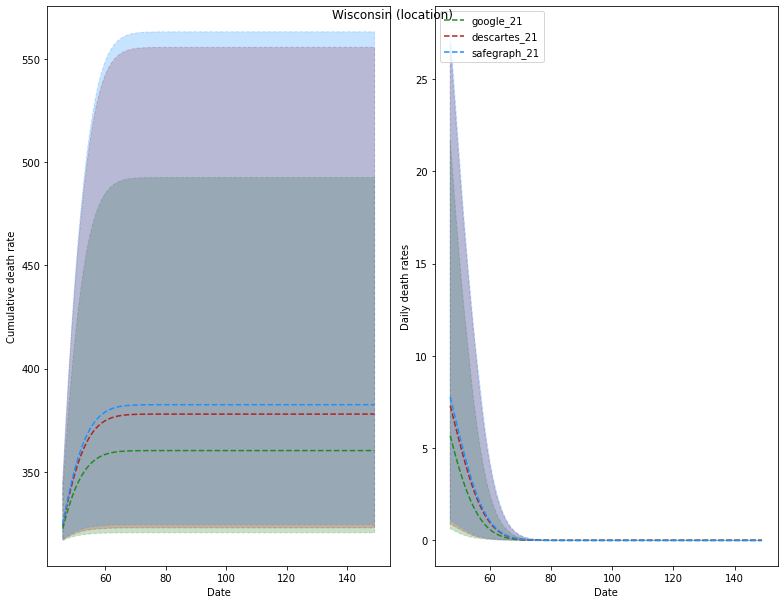

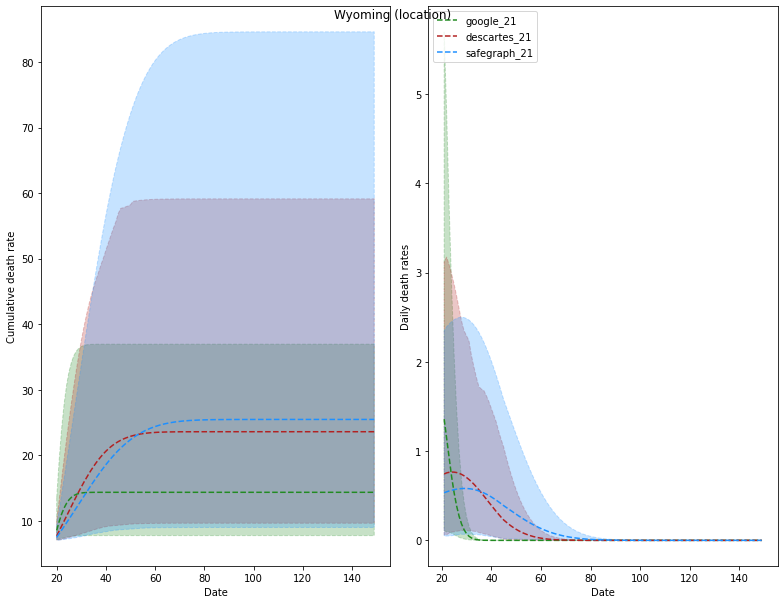

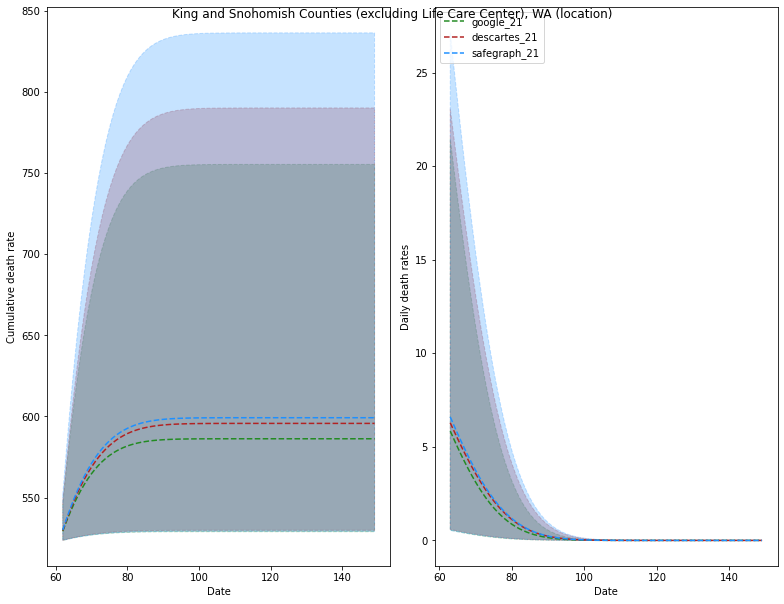

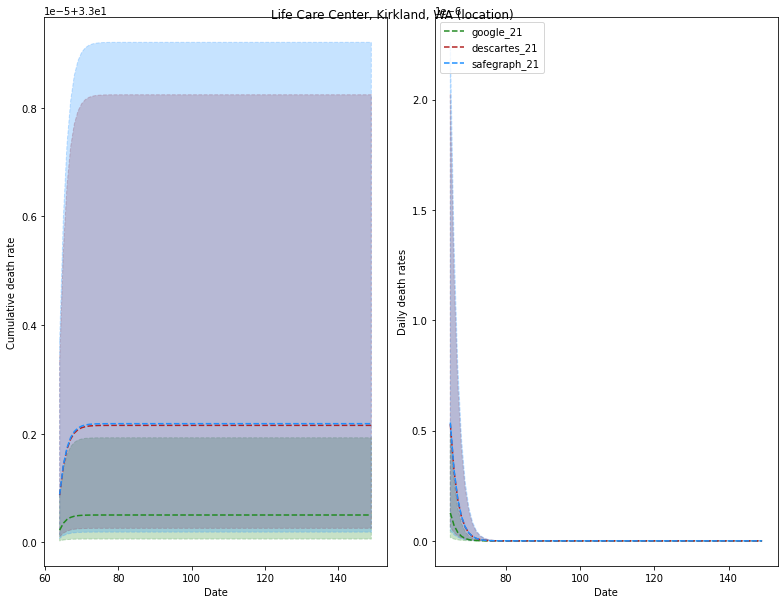

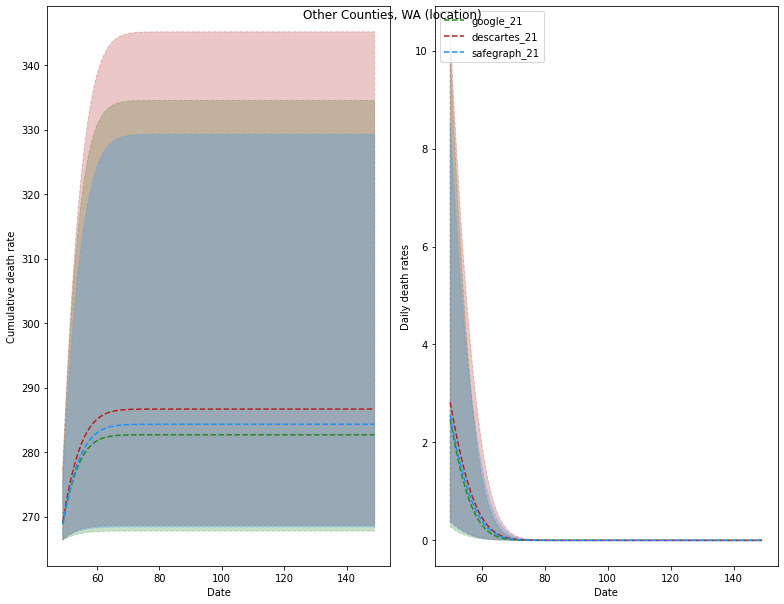

In [4]:
full_df = checkpoint.load('full_data')
age_pop_df = checkpoint.load('age_pop')
threshold_dates = checkpoint.load('threshold_dates')
submodel_dict = checkpoint.load('submodel_dict')
loc_df = checkpoint.load('location')

obs_df = full_df[full_df.location_id.isin(loc_df.location_id)]

draw_dfs, past_draw_dfs, models_used, days, ensemble_draws_dfs = runner.compile_draws(loc_df,
                                                                                      submodel_dict,
                                                                                      obs_df,
                                                                                      threshold_dates,
                                                                                      age_pop_df)

if 'location' not in models_used:
    raise ValueError('No location-specific draws used, must be using wrong tag')
draw_df = pd.concat(draw_dfs)
model_type_df = pd.DataFrame({'location': loc_df['Location'].tolist(),
                              'model_used': models_used})

# write
draw_df.to_csv(f'{OUTPUT_DIR}/state_data.csv', index=False)
model_type_df.to_csv(f'{OUTPUT_DIR}/state_models_used.csv', index=False)
ensemble_plot_path = runner.make_and_save_draw_plots(OUTPUT_DIR, loc_df,
                                                     ensemble_draws_dfs, days, models_used, age_pop_df)
print(ensemble_plot_path)
checkpoint.write('draw_data', draw_df)

## total US deaths in this run

In [5]:
draw_df = checkpoint.load('draw_data')

runner.display_total_deaths(draw_df)

2020-05-01 08:45:27.429 | INFO     | covid_model_deaths.deaths_io.checkpoint:load:30 - Loading draw_data from in memory cache.


82,233 (64,569 - 142,637)


## combine with previous predictions

In [ ]:
avg_df = runner.average_draws(raw_draw_path, yesterday_draw_path, before_yesterday_draw_path)
avg_df.to_csv(average_draw_path, index=False)
compare_average_plot_path = runner.make_and_save_compare_average_plots(OUTPUT_DIR,
                                                                       raw_draw_path,
                                                                       average_draw_path,
                                                                       yesterday_draw_path,
                                                                       before_yesterday_draw_path,
                                                                       'United States of America')

In [ ]:
compare_to_previous_plot_path = runner.make_and_save_compare_to_previous_plots(OUTPUT_DIR,
                                                                               raw_draw_path,
                                                                               yesterday_draw_path,
                                                                               label='United States')


In [ ]:
viz_dir = runner.send_plots_to_diagnostics(DATESTAMP_LABEL,
                                           f'{OUTPUT_DIR}/ensemble_plot.pdf',
                                           compare_average_plot_path,
                                           compare_to_previous_plot_path)
print(viz_dir)

In [ ]:
loc_df = checkpoint.load('location')
submodel_dict = checkpoint.load('submodel_dict')
draw_df = checkpoint.load('draw_data')
age_pop_df = checkpoint.load('age_pop')

pop_df = age_pop_df.groupby('location_id', as_index=False)['population'].sum()

def get_peak(location_id):
    submodel_dirs = submodel_dict[location_id]['submodel_dirs']
    dfs = []
    if os.path.exists(f'{submodel_dirs[0]}/{location_id}/gm_point_estimate.csv'):
        for submodel_dir in submodel_dirs:
            df = pd.read_csv(f'{submodel_dir}/{location_id}/gm_point_estimate.csv')
            df['Date'] = pd.to_datetime(df['Date'])
            dfs.append(df.sort_values('Date'))
        df = pd.concat(dfs).reset_index(drop=True)
    else:
        df = draw_df.loc[draw_df['location_id'] == location_id].copy()
        df = df.rename(index=str, columns={'date':'Date'})
        df = df.merge(pop_df)
        df['Age-standardized death rate'] = df[[f'draw_{d}' for d in range(1000)]].mean(axis=1) / df['population']
        df = df.sort_values('Date').reset_index(drop=True)
        df['Age-standardized death rate'][1:] = df['Age-standardized death rate'].values[1:] - df['Age-standardized death rate'].values[:-1]
        df = df.loc[~df['observed']]
        df = df[['location_id', 'Date', 'Age-standardized death rate']]
    df = df.groupby('Date', as_index=False)['Age-standardized death rate'].mean()
    peak_df = df.reset_index(drop=True)[15:]
    peak_df = peak_df.sort_values('Age-standardized death rate', ascending=False).reset_index(drop=True)

    peak_date = peak_df['Date'][0]
    df['peak_date'] = False
    df.loc[df['Date'] == peak_date, 'peak_date'] = True
    df['location_id'] = location_id

    return df

pred_df = pd.concat([get_peak(location_id) for location_id in loc_df['location_id'].to_list()])
pred_df = pred_df.rename(index=str, columns={'Age-standardized death rate':'Daily death rate'})
peak_dates_df = pred_df.loc[pred_df['peak_date']]

pred_df = pred_df[['location_id', 'Date', 'Daily death rate']].reset_index(drop=True)
pred_df.to_csv(f'{OUTPUT_DIR}/point_estimates.csv', index=False)
peak_dates_df = peak_dates_df[['location_id', 'Date', 'Daily death rate']].reset_index(drop=True)
peak_dates_df = peak_dates_df.rename(index=str, columns={'Date':'peak_date'})
peak_dates_df.to_csv(f'{OUTPUT_DIR}/peak_dates.csv', index=False)
